# Импорт библиотек

In [25]:
!pip install osmnx
!pip install haversine
!pip install geopy
!pip install folium
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [27]:
import torch  # pytorch
import json  # чтение json файла
import torch.nn as nn
import torch.optim as optim  # регуляризация модели
from torch.nn.utils.rnn import pad_sequence  # выраванивание последовательностей
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split  # разделение выборки на test/train
from sklearn.preprocessing import MinMaxScaler  # нормализация данных
from torch.masked import masked_tensor
import matplotlib.pyplot as plt
import torch.nn.functional as F

import random

import numpy as np
import osmnx as ox  # библиотека для работы с OSM
import networkx as nx  # для работы с графами местностей
from geopy.distance import geodesic as gd

from torch_geometric.nn import GATConv
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import geopandas as gpd

from haversine import haversine, Unit  # вычисление расстояний между точками кординат
from scipy.interpolate import interp1d  # интерполяция маршрутов

import os
import folium  # для построения html-запросов через leafnet и вывода маршрутов
from sklearn.metrics import mean_squared_error, mean_absolute_error  # метрики для модели

# Загрузка и предобработка данных

Подгрузка выборки в виде последовательностей координат в количестве 10000 штук (routes.json)

In [8]:
!gdown 1VYI0Mi5XTASGDon33RNMjdMlkCKynA0k

Downloading...
From (original): https://drive.google.com/uc?id=1VYI0Mi5XTASGDon33RNMjdMlkCKynA0k
From (redirected): https://drive.google.com/uc?id=1VYI0Mi5XTASGDon33RNMjdMlkCKynA0k&confirm=t&uuid=b923b059-23aa-471c-a533-e8b992ff02c9
To: /content/routes.json
100% 286M/286M [00:02<00:00, 106MB/s]


Загрузка данных выборки из файла

In [9]:
# Загрузка маршрутов
routes_path = "routes.json"
with (open(routes_path, 'r', encoding='utf-8')) as f:
    data = json.load(f)

X, y = data['X'], data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

Происходит выравнивание последовательностей в соответствии с самой длинной последовательностью и их преобразование в тензоры, далее следует нормализация в отрезок [-1; 1]. После выравнивания лишние элементы будут иметь координаты (0, 0). Затем данные загружаются в dataset и dataloader

Размер одного батча (отрезка) при обучении моделей = 64

In [10]:
sc = MinMaxScaler(feature_range=(-1, 1))
batch_size = 64

In [28]:
X_train = [torch.tensor(sc.fit_transform(seq), dtype=torch.float32) for seq in X_train]
y_train = [torch.tensor(sc.fit_transform(seq), dtype=torch.float32) for seq in y_train]
X_train_pad = pad_sequence(X_train, batch_first=True)
y_train_pad = pad_sequence(y_train, batch_first=True)

X_test = [torch.tensor(sc.fit_transform(seq), dtype=torch.float32) for seq in X_test]
y_test = [torch.tensor(sc.fit_transform(seq), dtype=torch.float32) for seq in y_test]
X_test_pad = pad_sequence(X_test, batch_first=True)
y_test_pad = pad_sequence(y_test, batch_first=True)

train_dataset = TensorDataset(X_train_pad, y_train_pad)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_pad, y_test_pad)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Рекуррентные нейронные сети

## 1) Простейшая LSTM

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # проходим через LSTM
        out, _ = self.lstm(x)
        # проходим через линейный слой
        out = self.fc(out)
        return out

**Загрузка обученной модели (опционально)**

Можно пропустить этап с обучением и сразу загрузить обученную модель (lstm_model.pth) с установившимися параметрами и перейти к шагу с [примером](https://colab.research.google.com/drive/1l7Huzgg3UWtsEOXKwKq9BCVu36yVRGG-#scrollTo=q4jUyVBLW1Ep&line=1&uniqifier=1). Подобное можно проделать и с остальными моделями.

### Параметры модели

In [13]:
# Параметры модели
input_size = 2
hidden_size = 64
output_size = 2
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM(input_size, hidden_size, output_size, num_layers)

# функция потерь и оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

### Обучение модели

In [14]:
num_epochs = 50  # Количество эпох при обучении
train_hist = []
test_hist = []
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:  # выборка разделяется на части (батчи)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)  # для каждого батча считается функция потерь

        # обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # расчёты для тестовых бачтей
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


KeyboardInterrupt: 

Графики функции ошибки для простой LSTM модели

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend();

In [ ]:
torch.save(model, './lstm.pth')

## 2) Двунаправленная LSTM

Слои LSTM являются двунаправленными, т.е. они могут работать как с данными из прошлого, так и с предсказанными, отсюда для линейного слоя размер скрытого слоя увеличен в 2 раза. Также был добавлен слой dropout, который отвечает за отключение неиспользуемых нейронов

In [4]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BidirectionalLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.2, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # проходим через LSTM
        out, _ = self.lstm(x)
        # проходим через линейный слой
        out = self.fc(out)
        return out


**Загрузка обученной модели (опционально)**

In [ ]:
!gdown 16Hbvud9yHTT22XZ4WLZ0g4JfWkjsikx1

Downloading...
From: https://drive.google.com/uc?id=16Hbvud9yHTT22XZ4WLZ0g4JfWkjsikx1
To: /content/lstm_model.pth
100% 546k/546k [00:00<00:00, 13.9MB/s]


### Параметры модели

Для модели были выбраны следующие параметры:
- входной и выходной размеры = 2, т.к. последовательность имеет размерность N x 2, т.е. ширина и долгота
- размер скрытого слоя LSTM = 64
- число слоёв LSTM = 2

Другие характеристики:
- В качестве функции ошибки была выбрана среднеквадратическая ошибка (MSE).
- Для регуляризации был выбран оптимизатор Adam, learning rate = 0.0005.

In [ ]:
# Параметры модели
input_size = 2
hidden_size = 64
output_size = 2
num_layers = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# создаём модель
model = BidirectionalLSTM(input_size, hidden_size, output_size, num_layers)

# функция потерь и оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.00005)

loss_fn = nn.MSELoss()

### Обучение модели

На обучение выделено 10 эпох.

In [ ]:
num_epochs = 50  # Количество эпох при обучении
train_hist = []
test_hist = []
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:  # выборка разделяется на части (батчи)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)  # для каждого батча считается функция потерь

        # обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [1/10] - Training Loss: 0.0203, Test Loss: 0.0040
Epoch [2/10] - Training Loss: 0.0040, Test Loss: 0.0037
Epoch [3/10] - Training Loss: 0.0037, Test Loss: 0.0036
Epoch [4/10] - Training Loss: 0.0036, Test Loss: 0.0035
Epoch [5/10] - Training Loss: 0.0035, Test Loss: 0.0034
Epoch [6/10] - Training Loss: 0.0035, Test Loss: 0.0034
Epoch [7/10] - Training Loss: 0.0033, Test Loss: 0.0033
Epoch [8/10] - Training Loss: 0.0032, Test Loss: 0.0032
Epoch [9/10] - Training Loss: 0.0030, Test Loss: 0.0030
Epoch [10/10] - Training Loss: 0.0029, Test Loss: 0.0028


Рассмотрим график функции ошибки для тренировочных и тестовых данных.

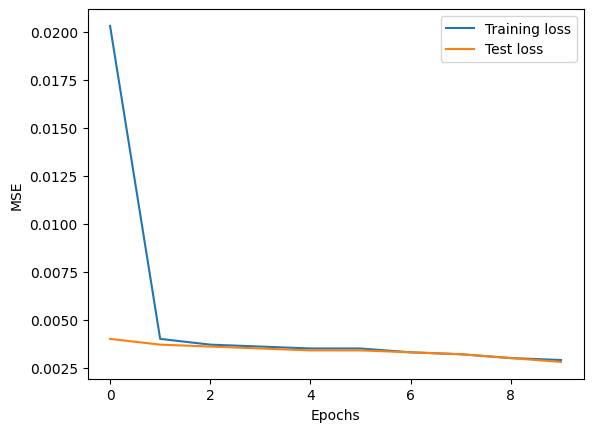

In [22]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend();

Параметры модели можно сохранить в отдельном файле

In [ ]:
torch.save(model, './lstm_bidir.pth')

## 3) Улучшенная модель LSTM

In [21]:
class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(EnhancedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Улучшенная LSTM с:
        # - Больше слоев
        # - Layer normalization
        # - Dropout между слоями
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0,
            bidirectional=False
        )

        # Layer normalization для стабилизации LSTM выходов
        self.ln1 = nn.LayerNorm(hidden_size)

        # Дополнительные полносвязные слои с residual connection
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, output_size)

        # Инициализация весов
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Устанавливаем forget gate bias в 1
                n = param.size(0)
                param.data[(n // 4):(n // 2)].fill_(1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm(x)
        out = self.ln1(out)

        # Первый полносвязный слой с residual connection
        residual = out
        out = self.fc1(out)
        out = self.ln2(out)
        out = F.leaky_relu(out, 0.1)
        out = self.dropout(out)
        out = out + residual[:, :, :self.hidden_size]  # residual connection

        # Final output layer
        out = self.fc2(out)
        return out

    def predict(self, x):
        """Инференс для одного маршрута"""
        self.eval()
        with torch.no_grad():
            if isinstance(x, (list, np.ndarray)):
                x = torch.FloatTensor(x).unsqueeze(0)  # add batch dim
            return self.forward(x).squeeze(0).cpu().numpy()

**Загрузка обученной модели (опционально)**

### Параметры модели

In [24]:
# Параметры модели
input_size = 2
hidden_size = 128
output_size = 2
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# создаём модель
model = EnhancedLSTM(input_size, hidden_size, output_size, num_layers)

# функция потерь и оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.00005)

loss_fn = nn.MSELoss()

### Обучение модели

In [23]:
num_epochs = 50  # Количество эпох при обучении
train_hist = []
test_hist = []
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:  # выборка разделяется на части (батчи)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)  # для каждого батча считается функция потерь

        # обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


KeyboardInterrupt: 

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend();

In [ ]:
torch.save(model, './lstm_enhanced.pth')

# Свёрточные нейронные сети

In [ ]:
import torch.nn.functional as F

## 1) Простейшая одномерная CNN

### Параметры модели

### Обучение модели

## 2) Улучшенная одномерная CNN

### Параметры модели

### Обучение модели

## 3) Одномерная CNN на основе encoder и decoder

In [11]:
class EncoderDecoder1dCNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=256, kernel_size=3, num_cnn_layers=4, dropout=0.2):
        super().__init__()

        # Расширяющаяся часть (encoder)
        self.encoder = nn.Sequential(
            nn.Conv1d(input_size, hidden_size // 4, kernel_size, padding='same'),
            nn.BatchNorm1d(hidden_size // 4),
            nn.Tanh(),
            nn.Dropout(dropout),

            nn.Conv1d(hidden_size // 4, hidden_size // 2, kernel_size, padding='same'),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Середина (с остаточными связями)
        self.mid_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden_size // 2, hidden_size // 2, kernel_size, padding='same'),
                nn.BatchNorm1d(hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(num_cnn_layers)
        ])

        # Сужающаяся часть (decoder)
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_size // 2, hidden_size // 4, kernel_size, padding='same'),
            nn.BatchNorm1d(hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(hidden_size // 4, input_size, kernel_size, padding='same'),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Encoder
        x = self.encoder(x)

        # Middle layers with residual connections
        for layer in self.mid_layers:
            x = x + layer(x)

        # Decoder
        x = self.decoder(x)

        return x.permute(0, 2, 1)

**Загрузка обученной модели (опционально)**

### Параметры модели

In [12]:
model = EncoderDecoder1dCNN()

# функция потерь и оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.MSELoss()

KeyboardInterrupt: 

### Обучение модели

In [ ]:
num_epochs = 100  # Количество эпох при обучении
train_hist = []
test_hist = []
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:  # выборка разделяется на части (батчи)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)  # для каждого батча считается функция потерь

        # обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # расчёты для тестовых бачтей
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


In [ ]:
torch.save(model, 'models/CNNs/cnn1d_1.pth')

# Ансамбли моделей

## Стэкинг GAT и LSTM

In [ ]:
class GNN_RNN(nn.Module):
    def __init__(self,
                 graph_data: "Data",
                 input_size=2,  # широта и долгота
                 hidden_size=128,
                 gnn_out_features=64,
                 num_gnn_layers=2,
                 num_lstm_layers=2,
                 num_heads=4,
                 dropout=0.2):
        super(GNN_RNN, self).__init__()

        self.graph_data = graph_data
        # GNN часть (используем Graph Attention Network)
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(GATConv(input_size, hidden_size, heads=num_heads, dropout=dropout))
        for _ in range(num_gnn_layers - 1):
            self.gnn_layers.append(GATConv(hidden_size * num_heads, hidden_size, heads=num_heads, dropout=dropout))

        self.gnn_to_lstm = nn.Linear(hidden_size * num_heads, gnn_out_features)

        # RNN часть (используем LSTM)
        self.lstm = nn.LSTM(input_size=gnn_out_features + input_size,  # объединяем координаты и признаки узлов
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            dropout=dropout if num_lstm_layers > 1 else 0,
                            bidirectional=False,
                            batch_first=True)

        # Выходной слой
        self.output_layer = nn.Linear(hidden_size, 1)  # предсказываем вероятность для каждого узла

        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.gnn_out_features = gnn_out_features

    def forward(self, route_sequence, node_candidates):
        """
        Args:
            route_sequence: [batch_size, seq_len, input_size] последовательность координат маршрута
            node_candidates: [batch_size, seq_len, max_candidates] кандидаты узлов для каждой точки маршрута
        Returns:
            [batch_size, seq_len, max_candidates] вероятности для каждого кандидата
        """
        batch_size, seq_len = route_sequence.size()[:2]
        max_candidates = node_candidates.size()[2]

        # 1. Обрабатываем граф с помощью GNN
        x, edge_index = self.graph_data.x, self.graph_data.edge_index
        for layer in self.gnn_layers:
            x = layer(x, edge_index)
            x = F.leaky_relu(x)
            x = self.dropout(x)

        x = self.gnn_to_lstm(x)  # [num_nodes, gnn_out_features]

        # 2. Для каждого шага маршрута собираем признаки кандидатов
        # node_candidates: [batch_size, seq_len, max_candidates]
        # x: [num_nodes, gnn_out_features] -> расширяем для всех кандидатов
        candidate_features = x[node_candidates.view(-1)].view(batch_size, seq_len, max_candidates,
                                                              self.gnn_out_features)

        # 3. Добавляем координаты маршрута к признакам кандидатов
        route_expanded = route_sequence.unsqueeze(2).expand(-1, -1, max_candidates, -1)
        lstm_input = torch.cat([candidate_features, route_expanded], dim=-1)

        # 4. Обрабатываем последовательность с помощью LSTM
        lstm_out, _ = self.lstm(lstm_input.view(-1, seq_len, self.gnn_out_features + 2))
        lstm_out = lstm_out.contiguous().view(batch_size, seq_len, max_candidates, self.hidden_size)

        # 5. Предсказываем вероятности для каждого кандидата
        logits = self.output_layer(lstm_out).squeeze(-1)  # [batch_size, seq_len, max_candidates]
        probs = torch.sigmoid(logits)

        return probs

    def predict(self, graph_data, route_sequence, node_candidates, k=1):
        """Предсказание топ-k наиболее вероятных узлов для каждого шага маршрута"""
        probs = self.forward(graph_data, route_sequence, node_candidates)
        topk_probs, topk_indices = torch.topk(probs, k=k, dim=2)
        return topk_indices, topk_probs

In [ ]:
# Загрузка графа дорог Воронежа
datapath = "training data"

# Атрибуты вершины: координаты, id, кол-вол улиц
nodes = gpd.read_file(os.path.join(datapath, "nodes.csv"), encoding="utf8")
nodes = nodes.iloc[:, :4]
nodes = nodes.astype('float32')

edges = gpd.read_file(os.path.join(datapath, "edges.csv"), encoding="utf8")
edge_index = edges[['u', 'v']]
edge_index = edge_index.astype('int64')

In [ ]:
nodes_t = torch.tensor(nodes.values)
edge_index_t = torch.tensor(edge_index.values)
graph = Data(x=nodes_t, edge_index=edge_index_t)

In [ ]:
print("Node features shape:", graph.x.shape)  # Должно быть [N, 2]
print("Edge index shape:", graph.edge_index.shape)  # Должно быть [2, E]

Node features shape: torch.Size([7352, 4])
Edge index shape: torch.Size([19200, 2])


In [ ]:
# Параметры модели
out_channels = 64
in_channels = 4
output_size = 2
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# создаём модель
model = GNN_RNN(graph).to(device)

# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.01)

# в качестве функции потерь - СТС, так как последовательности разнородной длины
loss_fn = nn.CTCLoss()

In [ ]:
X, y = data['X'], data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

In [ ]:
X_train = [torch.tensor(seq, dtype=torch.float32) for seq in X_train]
y_train = [torch.tensor(seq, dtype=torch.float32) for seq in y_train]
X_train_pad = pad_sequence(X_train, batch_first=True)
y_train_pad = pad_sequence(y_train, batch_first=True)

X_test = [torch.tensor(seq, dtype=torch.float32) for seq in X_test]
y_test = [torch.tensor(seq, dtype=torch.float32) for seq in y_test]
X_test_pad = pad_sequence(X_test, batch_first=True)
y_test_pad = pad_sequence(y_test, batch_first=True)

train_dataset = TensorDataset(X_train_pad, y_train_pad)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_pad, y_test_pad)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
num_epochs = 50  # Количество эпох при обучении
train_hist = []
test_hist = []
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:  # выборка разделяется на части (батчи)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)  # для каждого батча считается функция потерь

        # обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # расчёты для тестовых бачтей
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 19200 but got size 2 for tensor number 1 in the list.

# Тестирование моделей

Загрузка файла конфигурации (config.json). Он передаётся классу, который описан ниже.

In [ ]:
!gdown 1uTIYTjQHau5R0kOhQG3lspQ-EA16SHxp

Downloading...
From: https://drive.google.com/uc?id=1uTIYTjQHau5R0kOhQG3lspQ-EA16SHxp
To: /content/config.json
100% 163/163 [00:00<00:00, 397kB/s]


## Класс генератора маршрутов

Данный класс использовался для генерации 10.000 пар маршрутов для выборки. С помощью него также можно получить граф дорог, который получается с помощью заключения выбранной области в прямоугольник. Для этого выбирается верхняя левая и нижняя правая точки.

In [ ]:
class RouteGenerator:
    def __init__(self, config_path: str = "config.json", **kwargs):
        """Конструктор класса, которому в именованных аргументах передаётся
        либо название местности, либо точные координаты местности.
        Если было передано название, то происходит обращение к базе данных OSM,
        где потом извлекаются точные координаты. На основе координат строится граф дорог.


        Args:
            config_path (str, optional): Путь к файлу конфигурации. По умолчанию стоит "config.json".

        Raises:
            Exception: Не были переданы ни название местности, ни его координаты.
        """

        self.__load_config(config_path)
        self.data = {'X': [], 'y': []}

        if "place_name" in kwargs.keys():
            self.__place_bbox = list(
                ox.geocode_to_gdf(kwargs["place_name"]).geometry.total_bounds
            )

        elif "place_bbox" in kwargs.keys():
            self.__place_bbox = kwargs["place_bbox"]
        else:
            raise Exception(
                "Укажите название места согласно базе данных OSM либо координаты местности."
            )

        self.graph = ox.graph_from_bbox(self.__place_bbox, network_type="drive")  # Граф дорог местности

    def __load_config(self, file_path: str) -> None:
        """Загрузка данных о константах через файл конфигурации.

        Args:
            file_path (str): Путь к файлу конфигурации.
        """

        with open(file_path, "r") as file:
            config = json.load(file)
            self.__data_amount = config["data_amount"]  # Размер генерируемой выборки
            self.__min_segment = config[
                "min_segment"
            ]  # Минимальное значение отрезка для создания отклонения
            self.__max_segment = config[
                "max_segment"
            ]  # Максимальное значение отрезка для создания отклонения
            self.__min_offset = config["min_offset"]  # Минимальное отклонение
            self.__max_offset = config["max_offset"]  # Максимальное отклонение
            self.__max_route_len = config["max_route_len"]
            self.__min_route_len = config["min_route_len"]

    def save_false_route(self, main_route: list) -> tuple:
        """Генерация одного искажённого маршрута на основе исходного.

        Args:
            main_route: (list): Исходный маршрут.

        Returns:
            Tuple[nx.Graph, list]: Кортеж, внутри которого помещён изменённый граф и полученный маршрут.
        """

        path = main_route
        G = self.graph.copy()
        new_nodes = [path[0]]

        for i in range(len(path) - 1):
            # Начальная и конечная точки отрезка
            u, v = path[i], path[i + 1]
            point1 = (G.nodes[u]["y"], G.nodes[u]["x"])
            point2 = (G.nodes[v]["y"], G.nodes[v]["x"])

            # Расстояние между узлами
            edge_length = gd(point1, point2).meters
            direction_bearing = ox.bearing.calculate_bearing(
                point1[0], point1[1], point2[0], point2[1]
            )

            # Добавление точек через случайное расстояние между 20 и 60 метров
            current_dist = 0
            previous_node = u
            while current_dist < edge_length:
                # Случайное расстояние до следующей точки
                random_dist = random.uniform(self.__min_segment, self.__max_segment)
                current_dist += random_dist

                if current_dist >= edge_length:
                    break

                # Вычисление промежуточной точки
                new_point = gd(meters=current_dist).destination(
                    point1, direction_bearing
                )
                new_lat, new_lon = new_point.latitude, new_point.longitude

                # Случайное отклонение влево или вправо
                offset_direction = direction_bearing + (
                    90 if random.choice([True, False]) else -90
                )
                offset_dist = random.uniform(self.__min_offset, self.__max_offset)
                offset_point = gd(meters=offset_dist).destination(
                    (new_lat, new_lon), offset_direction
                )
                offset_lat, offset_lon = (offset_point.latitude, offset_point.longitude)

                # Добавление новой вершины и её координат
                new_node = max(G.nodes) + 1
                G.add_node(new_node, y=offset_lat, x=offset_lon)
                new_nodes.append(new_node)

                # Добавление ребра между новой точкой и предыдущей точкой
                G.add_edge(previous_node, new_node, length=random_dist)
                G.add_edge(
                    new_node, v, length=edge_length - current_dist
                )  # Связь с основным маршрутом

                previous_node = new_node  # Сместить начальную точку для следующего шага
            new_nodes.append(path[i + 1])

        false_route = [(G.nodes[n]["x"], G.nodes[n]["y"]) for n in new_nodes]
        return G, false_route

    def save_main_route(self) -> tuple:
        """Генерация и сохранение исходного маршрута

        Args: _
        """
        keys = list(self.graph.nodes.keys()).copy()
        node_ids = []

        while len(node_ids) < self.__min_route_len or len(node_ids) > self.__max_route_len:
            try:
                start = random.choice(keys)
                keys.remove(start)
                end = random.choice(keys)
                # Поиск кратчайшего пути
                node_ids = nx.astar_path(self.graph, start, end, weight="length")
            except nx.NetworkXNoPath:
                pass
        main_route = [(self.graph.nodes[n]["x"], self.graph.nodes[n]["y"])
                      for n in node_ids]
        return node_ids, main_route

    @staticmethod
    def calculate_cumulative_distances(route: "np.ndarray"):
        distances = [0]  # Начинаем с 0 элемента
        for i in range(1, len(route)):
            lon1, lat1 = route[i - 1]
            lon2, lat2 = route[i]
            distance = haversine((lon1, lat1), (lon2, lat2), unit=Unit.METERS)
            distances.append(distances[-1] + distance)
        return np.array(distances)

    # Функция для интерполяции маршрута

    def make_equal(self, route: list, num_points: int) -> list:
        route = np.array(route)
        # Вычисляем кумулятивное расстояние
        distances = self.calculate_cumulative_distances(route)

        # Создаем интерполяционные функции для широты и долготы
        interpolation_func_lon = interp1d(distances, route[:, 0], kind='linear')
        interpolation_func_lat = interp1d(distances, route[:, 1], kind='linear')

        new_distances = np.linspace(0, distances[-1], num_points)

        new_lon = interpolation_func_lon(new_distances)
        new_lat = interpolation_func_lat(new_distances)
        new_route = list(np.column_stack((new_lon, new_lat)))
        new_route = [tuple(point) for point in new_route]
        return new_route

    def save_data(self) -> None:
        for i in range(self.__data_amount):
            route_ids, main_route = self.save_main_route()
            _, false_route = self.save_false_route(route_ids)

            main_route = self.make_equal(main_route, len(false_route))
            self.data['y'].append(main_route)
            self.data['X'].append(false_route)
            if (i + 1) % 100 == 0:
                print(f"Сделано {i + 1}/{self.__data_amount} маршрутов")


## Функции для запуска примера

В качестве примера будут созданы 3 html-файла в папке example:
- *input* - входной маршрут
- *target* - целевой маршрут
- *predict* - предсказанный моделью маршрут

In [24]:
def save_route(points: list, save_folder: str, name: str) -> None:
    # Создаем карту, центрированную на первой точке
    points = [(point[1], point[0]) for point in points]
    plot = folium.Map(location=points[0], zoom_start=15)

    # Соединяем точки линией (маршрут)
    folium.PolyLine(points, color="red", weight=2, opacity=1).add_to(plot)

    # Сохраняем карту в HTML-файл и открываем его
    plot.save(f"{save_folder}/{name}.html")


def model_test(save_folder: str, trained_model: "nn.Module") -> None:
    os.makedirs(save_folder, exist_ok=True)
    test_model = trained_model
    test_model.eval()

    sc = MinMaxScaler(feature_range=(-1, 1))

    place_bbox = [39.0296, 51.7806, 39.3414, 51.5301]

    generator = RouteGenerator(place_bbox=place_bbox, config_path="configs\\config.json")
    G, result = generator.graph, generator.save_main_route()
    main_ids, main_coords = result
    G_false, false_coords = generator.save_false_route(main_ids)

    main_coords = generator.make_equal(main_coords, len(false_coords))

    save_route(main_coords, save_folder, "target")
    save_route(false_coords, save_folder, "input")

    false_coords = torch.tensor(sc.fit_transform(false_coords), dtype=torch.float32)
    with torch.no_grad():
        predict = test_model(false_coords)
    predict = sc.inverse_transform(predict.detach().numpy())
    print(predict)
    save_route(predict, save_folder, "predict")
    print(f"MSE: {mean_squared_error(predict, main_coords)} \t MAE: {mean_absolute_error(predict, main_coords)}")


## Тестирование RNN

## Тестирование 1dCNN

## Тестирование ансамблей